# TabArena get tasks

In [4]:
from tabrepo.nips2025_utils.tabarena_context import TabArenaContext
tabarena_context = TabArenaContext()
paper_results = tabarena_context.load_results_paper(download_results="auto")

In [5]:
nonimputed_datasets = paper_results[(paper_results['method'] == 'TABPFNV2_GPU (default)') & (paper_results['imputed'] == False)].dataset.unique().tolist()

In [6]:
full_dataset_list = paper_results.dataset.unique().tolist()

In [7]:
large_datasets = list(set(full_dataset_list).difference(set(nonimputed_datasets)))

In [8]:
# select long task + classification
from tabrepo.benchmark.task.openml import OpenMLS3TaskWrapper, OpenMLTaskWrapper

import openml

from tabrepo.benchmark.models.ag.tabpfnv2.tabpfnv2_model import TabPFNV2Model

from tabrepo.models.tabpfnv2.generate import (
    gen_tabpfnv2,          # CustomAGConfigGenerator instance
    search_space_func,     # helper that samples HP configs
    prepare_tabpfnv2_config,
)

# one default + N random hyper-parameter configs
experiments = gen_tabpfnv2.generate_all_bag_experiments(
    num_random_configs=0,   # 0 = only the default config
)

# Get all tasks from TabArena-v0.1
task_metadata = []
task_ids = openml.study.get_suite("tabarena-v0.1").tasks
for i in range(51):
    task_id = task_ids[i]
    task = OpenMLTaskWrapper.from_task_id(task_id=task_id)
    dataset_id = task.dataset_id
    dataset = openml.datasets.get_dataset(dataset_id)
    dataset_name = dataset.name
    dataset_size = len(task.X)
    if dataset_name in large_datasets:
        task_metadata.append({
            'task': task,
            'task_id': task_id,
            'dataset_id': dataset_id,
            'dataset_name': dataset_name,
            'dataset_size': dataset_size,
            'problem_type': task.problem_type,
        })

/home/renat/miniconda3/envs/pytorch/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Getting task 363612
Got task 363612
Getting task 363613
Got task 363613
Getting task 363614
Got task 363614
Getting task 363615
Got task 363615
Getting task 363616
Got task 363616
Getting task 363618
Got task 363618
Getting task 363619
Got task 363619
Getting task 363620
Got task 363620
Getting task 363621
Got task 363621
Getting task 363623
Got task 363623
Getting task 363624
Got task 363624
Getting task 363625
Got task 363625
Getting task 363626
Got task 363626
Getting task 363627
Got task 363627
Getting task 363628
Got task 363628
Getting task 363629
Got task 363629
Getting task 363630
Got task 363630
Getting task 363631
Got task 363631
Getting task 363632
Got task 363632
Getting task 363671
Got task 363671
Getting task 363672
Got task 363672
Getting task 363673
Got task 363673
Getting task 363674
Got task 363674
Getting task 363675
Got task 363675
Getting task 363676
Got task 363676
Getting task 363677
Got task 363677
Getting task 363678
Got task 363678
Getting task 363679
Got task

In [9]:
task_metadata

[{'task': <tabrepo.benchmark.task.openml.task_wrapper.OpenMLTaskWrapper at 0x7fb777a2b810>,
  'task_id': 363613,
  'dataset_id': 46905,
  'dataset_name': 'Amazon_employee_access',
  'dataset_size': 32769,
  'problem_type': 'binary'},
 {'task': <tabrepo.benchmark.task.openml.task_wrapper.OpenMLTaskWrapper at 0x7fb7777c5a10>,
  'task_id': 363616,
  'dataset_id': 46908,
  'dataset_name': 'APSFailure',
  'dataset_size': 76000,
  'problem_type': 'binary'},
 {'task': <tabrepo.benchmark.task.openml.task_wrapper.OpenMLTaskWrapper at 0x7fb7777f2410>,
  'task_id': 363618,
  'dataset_id': 46910,
  'dataset_name': 'bank-marketing',
  'dataset_size': 45211,
  'problem_type': 'binary'},
 {'task': <tabrepo.benchmark.task.openml.task_wrapper.OpenMLTaskWrapper at 0x7fb752087f10>,
  'task_id': 363620,
  'dataset_id': 46912,
  'dataset_name': 'Bioresponse',
  'dataset_size': 3751,
  'problem_type': 'binary'},
 {'task': <tabrepo.benchmark.task.openml.task_wrapper.OpenMLTaskWrapper at 0x7fb779ffccd0>,
  't

# Manual test

In [ ]:
import os
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, os.environ.get("PYTHONPATH") + "/src")
sys.path

from tabpfn.classifier import TabPFNClassifier
from tabpfn.regressor import TabPFNRegressor

In [10]:
# from tabpfn.extensions.replace_chunk_attn import enable_chunked_attention
from tabpfn.extensions.replace_chunk_attn_computation import enable_chunked_attention

# enable_chunked_attention(chunk_size=1024)
enable_chunked_attention(chunk_size=256, batch_size=512)

[TabPFN] ▶ Enabled chunked self‑attention (chunk_size=256, batch_size=512)


In [11]:
from tabrepo.benchmark.task.openml import OpenMLS3TaskWrapper, OpenMLTaskWrapper

task = OpenMLTaskWrapper.from_task_id(task_id=363677)
X, y = task.X, task.y

Getting task 363677
Got task 363677


In [12]:
X.shape

(3845, 1617)

In [13]:
y

0       CM
1       CI
2       CI
3       CI
4       CI
        ..
3840    CI
3841    CI
3842    CI
3843    CI
3844    CI
Name: CompoundActivity, Length: 3845, dtype: category
Categories (3, object): ['CA', 'CI', 'CM']

In [14]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ------------------------------------------------------------------
# Feature encoding (safe for unseen categories)
# ------------------------------------------------------------------
def fit_feature_encoders(df: pd.DataFrame):
    encoders = {}
    for c in df.columns:
        if df[c].dtype in ("object", "category"):
            # Map known categories to ints
            cats = pd.Categorical(df[c].astype(str)).categories.tolist()
            encoders[c] = {"cats": {v: i for i, v in enumerate(cats)}}
    return encoders

def transform_features(df: pd.DataFrame, encoders: dict) -> pd.DataFrame:
    cols = []
    for c in df.columns:
        if c in encoders:
            mapping = encoders[c]["cats"]
            # Unknown -> new index
            ser = df[c].astype(str).map(mapping)
            unk_mask = ser.isna()
            if unk_mask.any():
                start = len(mapping)
                # assign incremental ids to unknowns
                unknown_vals = df[c].astype(str)[unk_mask].unique().tolist()
                for v in unknown_vals:
                    mapping[v] = start
                    start += 1
                ser = df[c].astype(str).map(mapping)
            cols.append(ser.astype("int64").rename(c))
        else:
            cols.append(df[c])
    return pd.concat(cols, axis=1)

# ------------------------------------------------------------------
# Target encoding
# ------------------------------------------------------------------
def encode_target(y_train_raw, y_test_raw, problem_type):
    if problem_type == "regression":
        return y_train_raw, y_test_raw, None  # no encoder
    le = LabelEncoder().fit(y_train_raw)
    y_tr = le.transform(y_train_raw)
    y_te = le.transform(y_test_raw)
    return y_tr, y_te, le

In [15]:
seed = 0
context_len = 10_000
problem_type = task.problem_type


# split
X_tr, X_te, y_tr_raw, y_te_raw = train_test_split(
    X, y, test_size=0.2, random_state=seed,
    stratify=y if problem_type != "regression" else None
)

# enforce same order after slicing
if context_len > 0:
    X_tr = X_tr.iloc[:context_len].copy().reset_index(drop=True)
    y_tr_raw = y_tr_raw.iloc[:context_len].copy().reset_index(drop=True)
else:
    X_tr = X_tr.reset_index(drop=True)
    y_tr_raw = y_tr_raw.reset_index(drop=True)

X_te = X_te.reset_index(drop=True)
y_te_raw = y_te_raw.reset_index(drop=True)

# feature encoding
encoders = fit_feature_encoders(X_tr)
X_tr = transform_features(X_tr, encoders)
X_te = transform_features(X_te, encoders)

# target encoding / normalization
y_tr, y_te, le_y = encode_target(y_tr_raw, y_te_raw, problem_type)
y_mean = y_std = None
if problem_type == "regression":
    y_mean, y_std = np.mean(y_tr), np.std(y_tr) or 1.0
    y_tr = (y_tr - y_mean) / y_std

In [16]:
device = "cuda"
if problem_type in ("binary", "multiclass"):
    model = TabPFNClassifier(device=device, ignore_pretraining_limits=True)
else:
    model = TabPFNRegressor(device=device, ignore_pretraining_limits=True)

# fit
model.fit(X_tr.values, y_tr)

/home/renat/chunk-tabpfn/src/tabpfn/classifier.py:422: UserWarning: Number of features 1617 is greater than the maximum Number of features 500 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


TabPFNClassifier(device='cuda', ignore_pretraining_limits=True)

In [17]:
# predict
proba = model.predict_proba(X_te.values)

In [18]:
# chunk
proba

array([[0.0273805 , 0.9278669 , 0.04475261],
       [0.0183522 , 0.9628744 , 0.01877339],
       [0.01712624, 0.9608234 , 0.02205034],
       ...,
       [0.01062443, 0.981154  , 0.00822154],
       [0.01645897, 0.961876  , 0.02166504],
       [0.01533724, 0.96623963, 0.01842314]], dtype=float32)

In [11]:
# no chunk
proba

array([[9.9894828e-01, 1.0074952e-03, 4.4261793e-05],
       [9.9312729e-01, 6.8652909e-03, 7.4342784e-06],
       [9.9871612e-01, 1.2599503e-03, 2.3968540e-05],
       ...,
       [9.9727726e-01, 2.5868851e-03, 1.3585897e-04],
       [9.8149806e-01, 1.8494718e-02, 7.1837635e-06],
       [4.4988278e-02, 3.8144889e-03, 9.5119721e-01]], dtype=float32)

# Analyze results

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
PATH_NO_CHUNK = "~/code/chunk-tabpfn/results/tabarena_long_nochunk.csv"
PATH_CHUNK    = "~/code/chunk-tabpfn/results/tabarena_long_chunk.csv"

df_no  = pd.read_csv(PATH_NO_CHUNK)
df_ch  = pd.read_csv(PATH_CHUNK)

# filter out context len <10,000 for no
df_no = df_no[df_no["context_len"] <= 10_000]

# filter out only those datasets for which max context >= 10000
datasets = []
for dataset in list(set(df_ch["dataset_name"].tolist() + df_no["dataset_name"].tolist())):
    max_context = max(
        df_ch[df_ch["dataset_name"] == dataset]["context_len"].max(),
        df_no[df_no["dataset_name"] == dataset]["context_len"].max()
    )
    if max_context >= 10_000:
        datasets.append(dataset)
df_no = df_no[df_no["dataset_name"].isin(datasets)]
df_ch = df_ch[df_ch["dataset_name"].isin(datasets)]

df_no["Attention"] = 'Baseline'
df_ch["Attention"] = 'Chunked'
df = pd.concat([df_no, df_ch], ignore_index=True)
df = df.rename(
    columns=
    {
        "auc": "AUC", 
        "rmse": "RMSE", 
        "context_len": 
        "Context Length",
        "acc": "Accuracy", 
    }
)

# Total time 
df["Total Time"] = df["fit_time_s"] + df["eval_time_s"]
df["Total Memory"] = df["fit_mem_mb"] + df["eval_mem_mb"]

In [69]:
df.head(10)

,task_id,dataset_name,problem_type,Context Length,use_chunk,chunk_size,seed,fit_time_s,eval_time_s,fit_mem_mb,eval_mem_mb,AUC,Accuracy,r2,RMSE,Attention,Total Time,Total Memory
0,363630,Diabetes130US,binary,1000,0,1024,1,0.325617,4.726078,0.000,2773.223633,0.591689,0.911983,0.000000,0.000000,Baseline,5.051695,2773.223633
1,363631,diamonds,regression,1000,0,1024,1,0.411462,5.311553,0.000,5363.186523,0.000000,0.000000,0.977107,598.354932,Baseline,5.723016,5363.186523
2,363631,diamonds,regression,2000,0,1024,1,0.441917,1.485276,8.125,5363.656250,0.000000,0.000000,0.979438,567.067952,Baseline,1.927193,5371.781250
3,363630,Diabetes130US,binary,2000,0,1024,1,0.241827,1.584761,8.125,3017.072754,0.612672,0.911983,0.000000,0.000000,Baseline,1.826588,3025.197754
4,363631,diamonds,regression,3000,0,1024,1,0.473560,1.616630,8.125,5363.656250,0.000000,0.000000,0.980580,551.095982,Baseline,2.090190,5371.781250
5,363630,Diabetes130US,binary,3000,0,1024,1,0.391974,1.817080,8.125,3198.851074,0.622105,0.911983,0.000000,0.000000,Baseline,2.209054,3206.976074
6,363631,diamonds,regression,4000,0,1024,1,0.537168,1.757307,8.125,5363.656250,0.000000,0.000000,0.980590,550.953463,Baseline,2.294475,5371.781250
7,363630,Diabetes130US,binary,4000,0,1024,1,0.433522,2.111325,8.125,3452.486816,0.624591,0.911983,0.000000,0.000000,Baseline,2.544847,3460.611816
8,363631,diamonds,regression,5000,0,1024,1,0.586977,1.896435,8.125,5363.656250,0.000000,0.000000,0.980916,546.318960,Baseline,2.483412,5371.781250
9,363630,Diabetes130US,binary,5000,0,1024,1,0.496920,2.379024,8.125,3639.718750,0.625380,0.911983,0.000000,0.000000,Baseline,2.875945,3647.843750


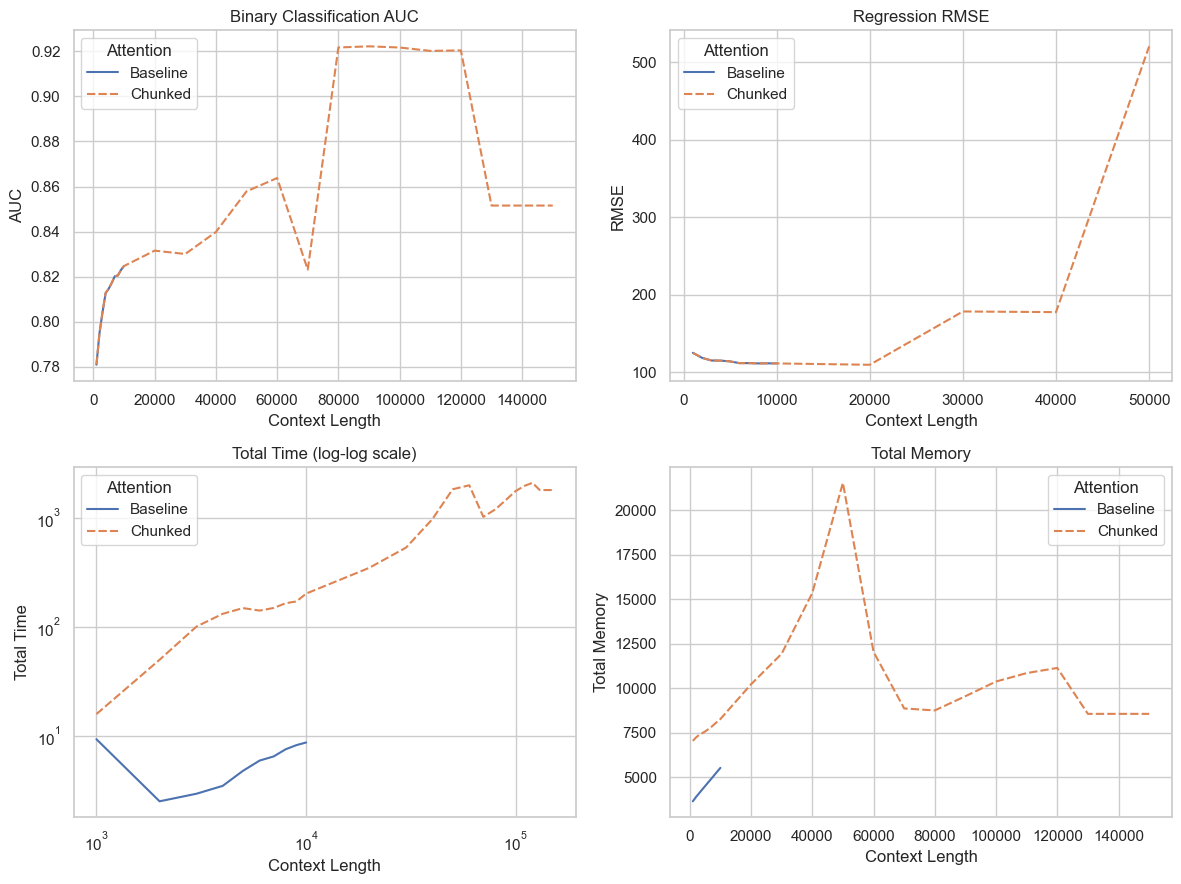

In [70]:
# set theme for sns as "whitegrid"
sns.set_theme(style="whitegrid")

# make grid of 4 plots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# binary classification
sns.lineplot(
    df[(df["problem_type"] == "binary")],
        # | (df["problem_type"] == "multiclass")], 
    x="Context Length", 
    y="AUC",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[0, 0]
)

# regression 
sns.lineplot(
    df[df["problem_type"] == "regression"], 
    x="Context Length", 
    y="RMSE",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[0, 1]
)

# fitting time
sns.lineplot(
    df, 
    x="Context Length", 
    y="Total Time",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[1, 0]
)
# log-log scale
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')

# Memory
sns.lineplot(
    df, 
    x="Context Length", 
    y="Total Memory",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[1, 1]
)

# set titles
handles, labels = axs[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0, 0].set_title("Binary Classification AUC")
axs[0, 1].set_title("Regression RMSE")
axs[1, 0].set_title("Total Time (log-log scale)")
axs[1, 1].set_title("Total Memory")
plt.tight_layout()
plt.show()

# save as pdf
fig.savefig("./figures/tabarena_long_results.pdf", bbox_inches='tight', dpi=300)

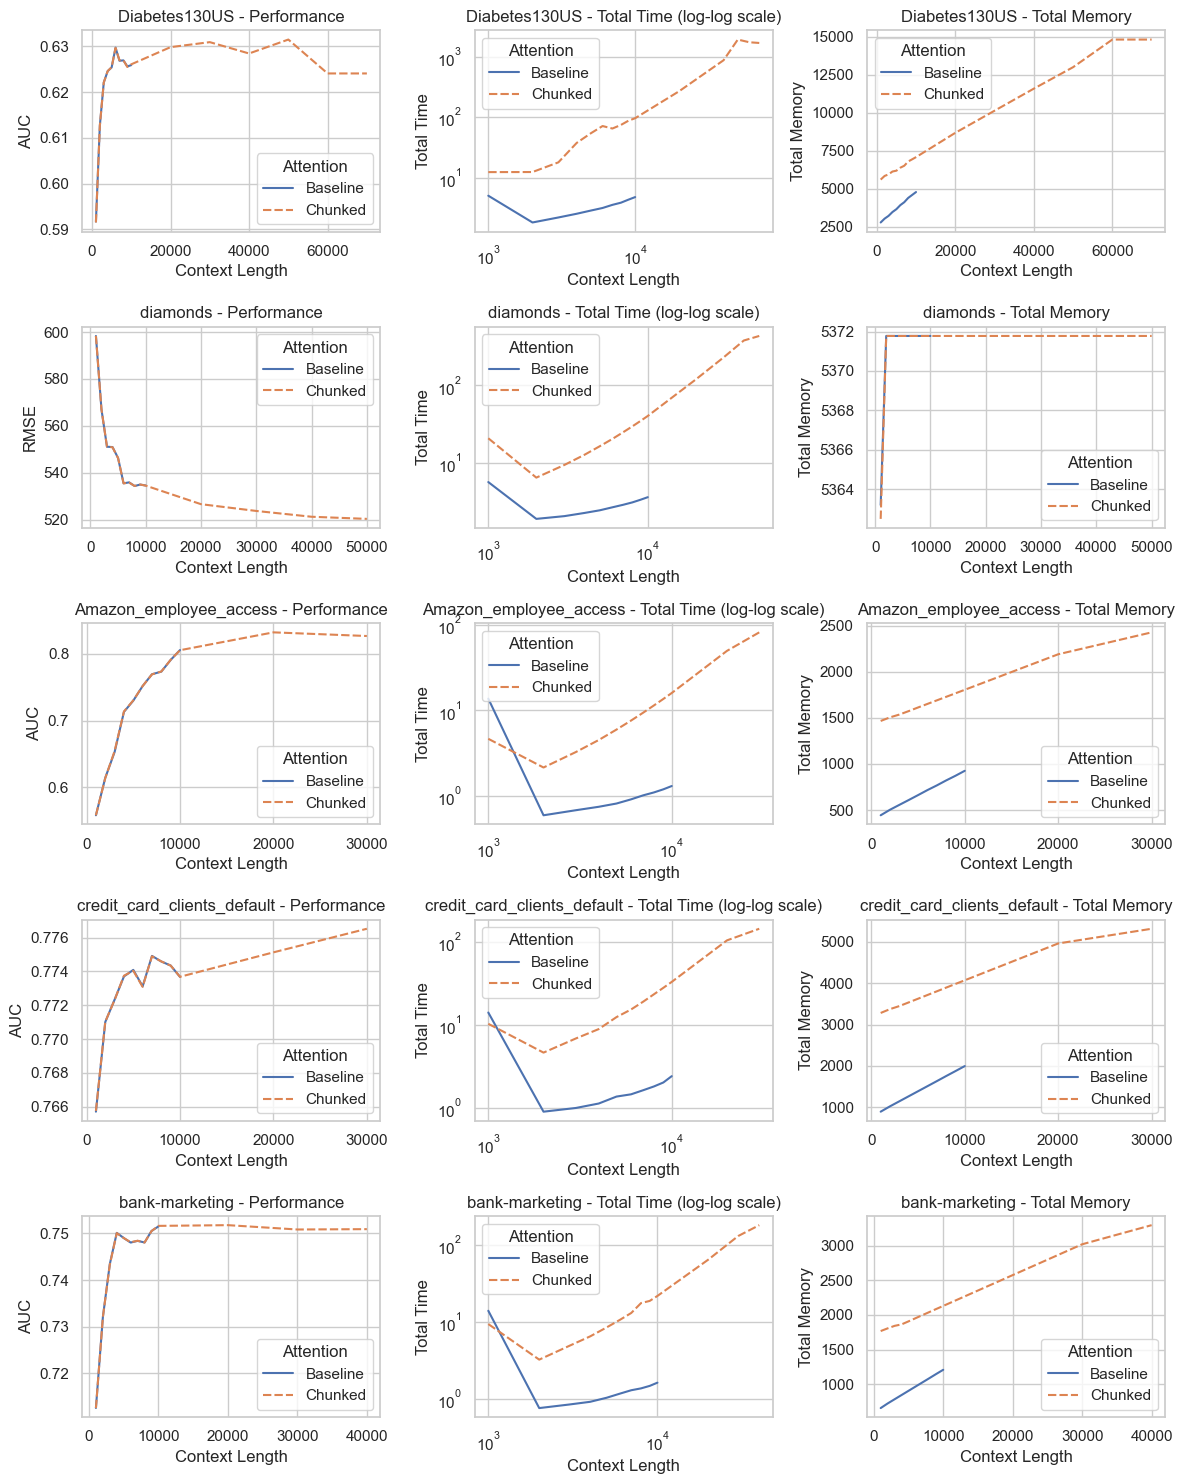

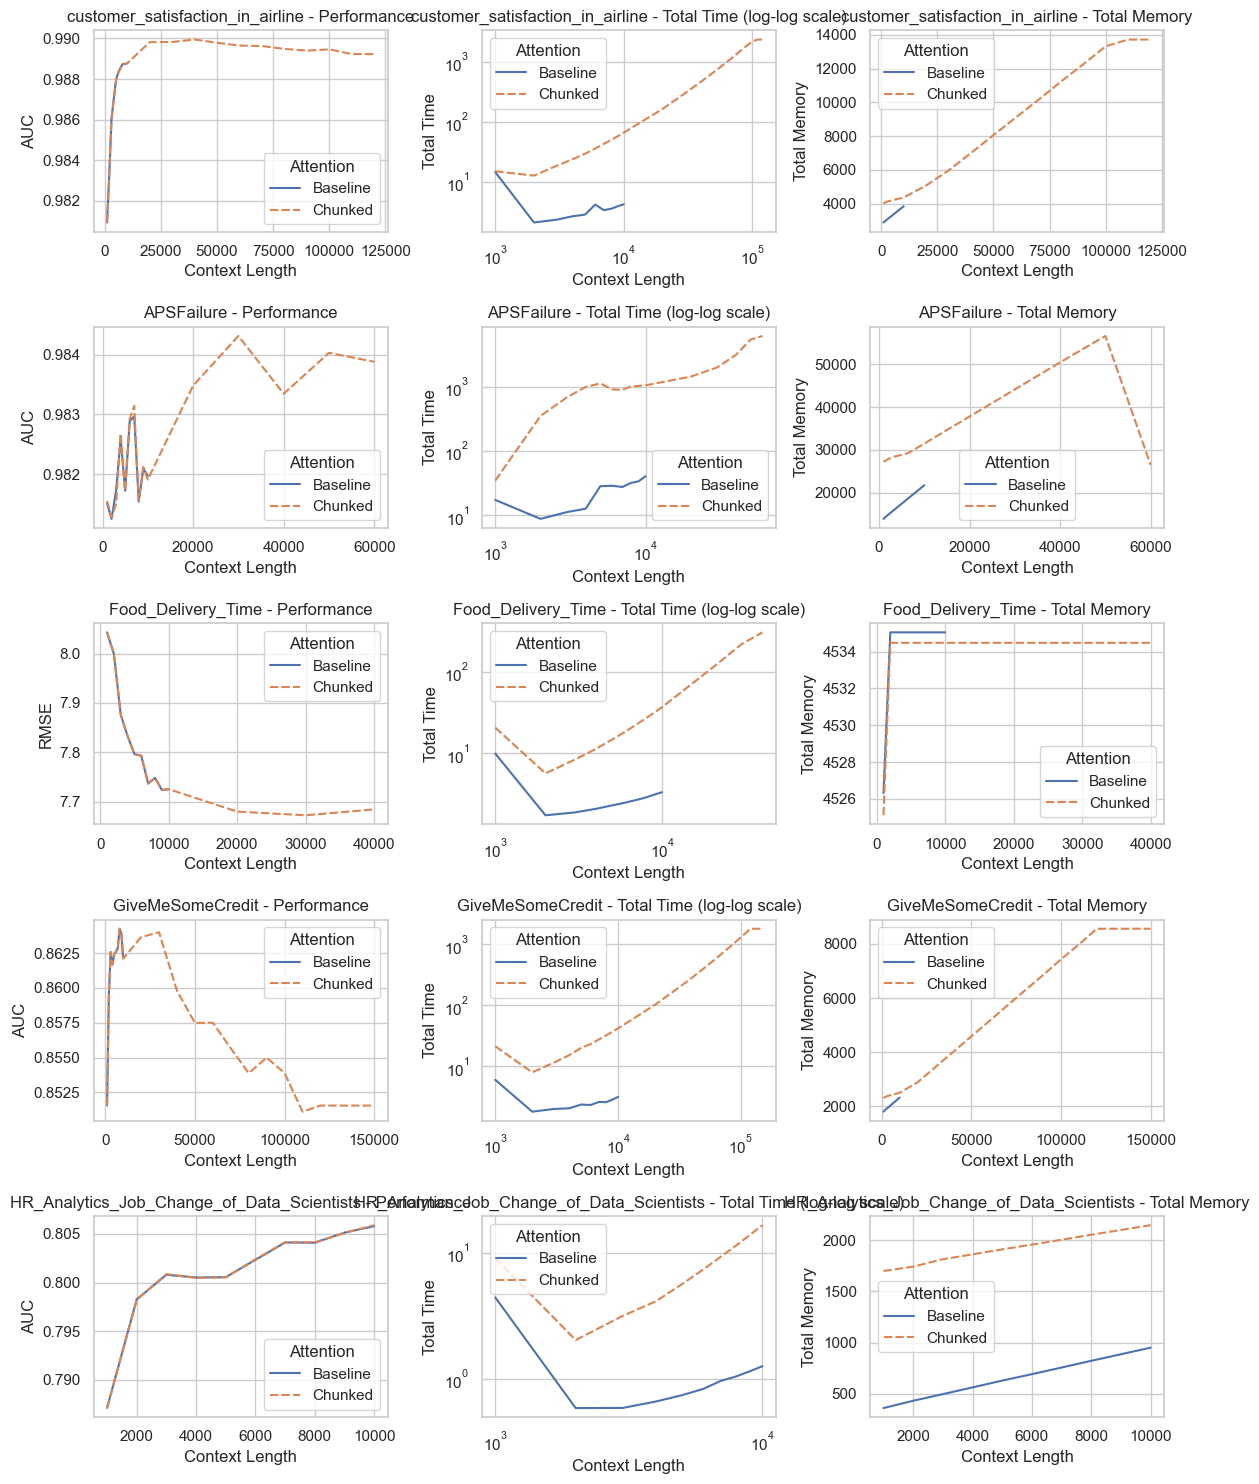

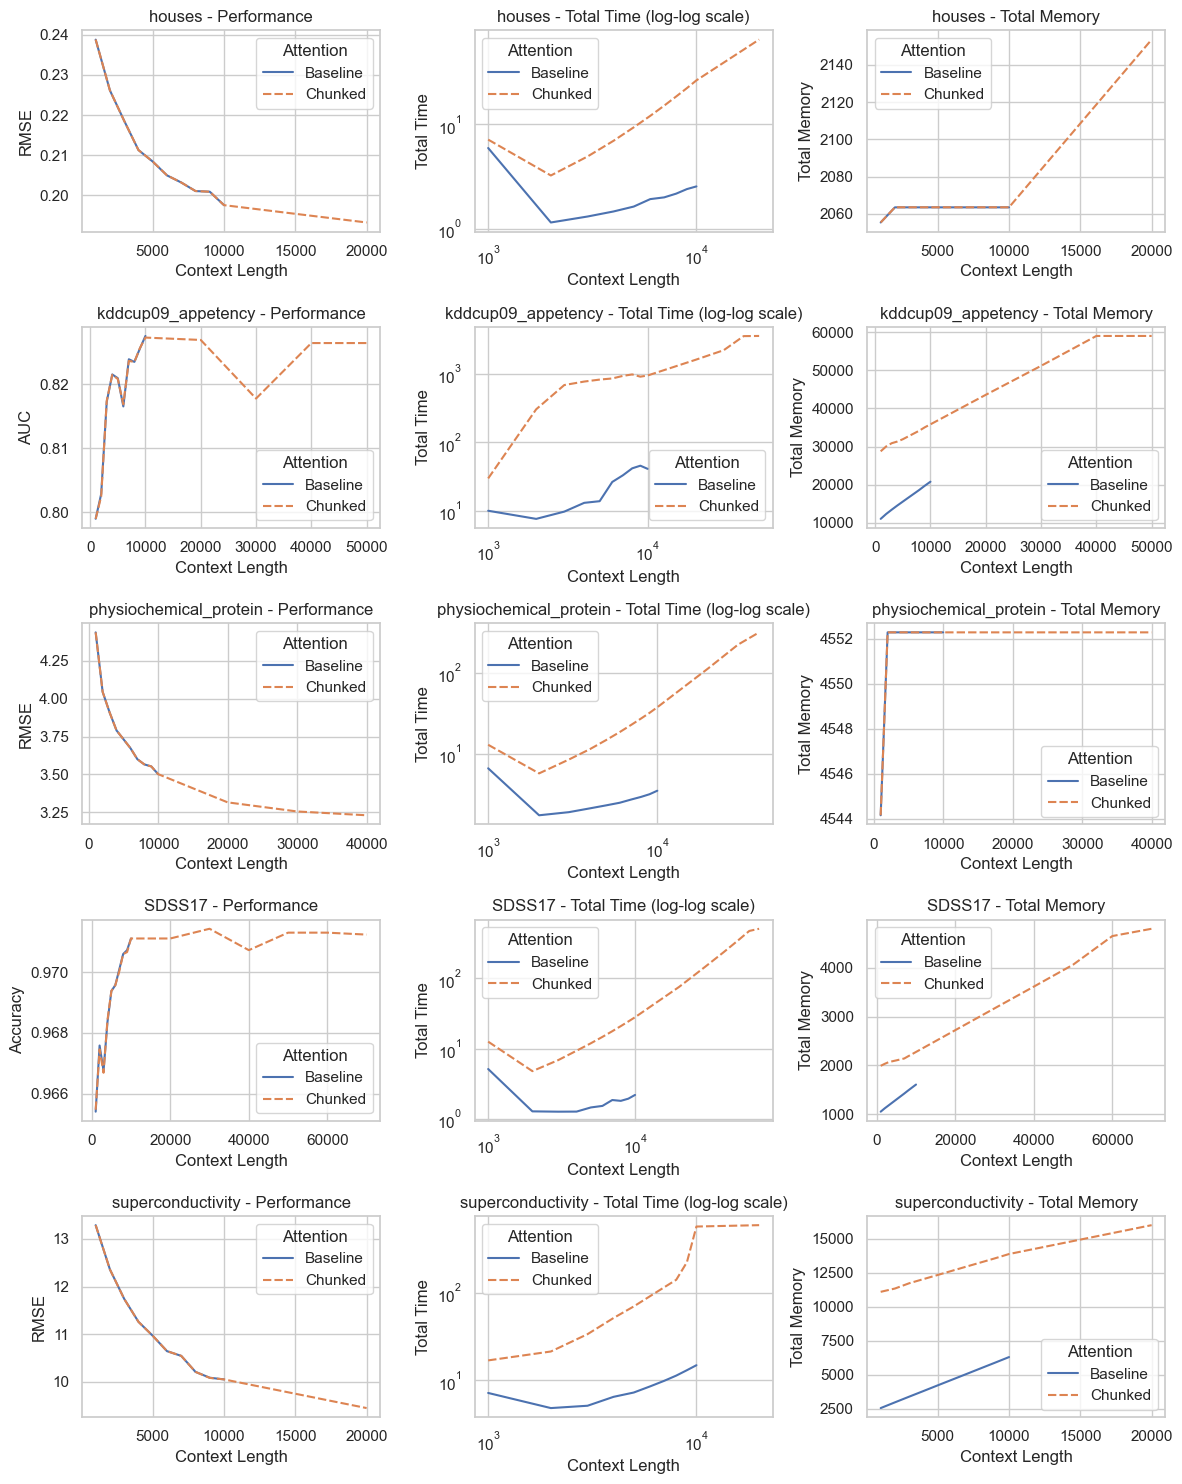

In [75]:
def plot_results(datasets, save_path):
    fig, axs = plt.subplots(len(datasets), 3, figsize=(12, 3 * len(datasets)))
    for i, dataset in enumerate(datasets):
        df_dataset = df[df["dataset_name"] == dataset]
        
        if df_dataset.problem_type.values[0] == "multiclass":
            sns.lineplot(
                df_dataset,
                x="Context Length",
                y="Accuracy",
                hue="Attention",
                style="Attention",
                errorbar=None,  # disable error bars
                ax=axs[i, 0]
            )
        elif df_dataset.problem_type.values[0] == "regression":
            sns.lineplot(
                df_dataset,
                x="Context Length",
                y="RMSE",
                hue="Attention",
                style="Attention",
                errorbar=None,  # disable error bars
                ax=axs[i, 0]
            )
        else:
            sns.lineplot(
                df_dataset,
                x="Context Length",
                y="AUC",
                hue="Attention",
                style="Attention",
                errorbar=None,  # disable error bars
                ax=axs[i, 0]
            )
        
        # fitting time
        sns.lineplot(
            df_dataset, 
            x="Context Length", 
            y="Total Time",
            hue="Attention",
            style="Attention",
            errorbar=None,  # disable error bars
            ax=axs[i, 1]
        )
        axs[i, 1].set_xscale('log')
        axs[i, 1].set_yscale('log')

        # memory
        sns.lineplot(
            df_dataset, 
            x="Context Length", 
            y="Total Memory",
            hue="Attention",
            style="Attention",
            errorbar=None,  # disable error bars
            ax=axs[i, 2]
        )

        # set titles
        axs[i, 0].set_title(f"{dataset} - Performance")
        axs[i, 1].set_title(f"{dataset} - Total Time (log-log scale)")
        axs[i, 2].set_title(f"{dataset} - Total Memory")
    plt.tight_layout()
    fig.savefig(save_path, bbox_inches='tight', dpi=300)

datasets = df.dataset_name.unique().tolist()
plot_results(datasets[:5], "./figures/tabarena_long_results_per_dataset_1.pdf") 
plot_results(datasets[5:10], "./figures/tabarena_long_results_per_dataset_2.pdf")
plot_results(datasets[10:15], "./figures/tabarena_long_results_per_dataset_3.pdf")




In [73]:
len(datasets)

15

# Analyze results (flashattn)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATH_NO_CHUNK = "~/chunk-tabpfn/results_flashattn/tabarena_long_nochunk.csv"
PATH_CHUNK    = "~/chunk-tabpfn/results_flashattn/tabarena_long_chunk.csv"

df_no  = pd.read_csv(PATH_NO_CHUNK)
df_ch  = pd.read_csv(PATH_CHUNK)

# filter out context len <10,000 for no
df_no = df_no[df_no["context_len"] <= 10_000]

# filter out only those datasets for which max context >= 10000
datasets = []
for dataset in list(set(df_ch["dataset_name"].tolist() + df_no["dataset_name"].tolist())):
    max_context = max(
        df_ch[df_ch["dataset_name"] == dataset]["context_len"].max(),
        df_no[df_no["dataset_name"] == dataset]["context_len"].max()
    )
    if max_context >= 10_000:
        datasets.append(dataset)
df_no = df_no[df_no["dataset_name"].isin(datasets)]
df_ch = df_ch[df_ch["dataset_name"].isin(datasets)]

df_no["Attention"] = 'Baseline'
df_ch["Attention"] = 'Chunked'
df = pd.concat([df_no, df_ch], ignore_index=True)
df = df.rename(
    columns=
    {
        "auc": "AUC", 
        "rmse": "RMSE", 
        "context_len": 
        "Context Length",
        "acc": "Accuracy", 
    }
)

# Total time 
df["Total Time (s)"] = df["fit_time_s"] + df["eval_time_s"]
df["Total Memory (MB)"] = df["fit_mem_mb"] + df["eval_mem_mb"]

In [3]:
df.head(10)

,task_id,dataset_name,problem_type,Context Length,use_chunk,chunk_size,seed,fit_time_s,eval_time_s,fit_mem_mb,eval_mem_mb,AUC,Accuracy,r2,RMSE,Attention,Total Time (s),Total Memory (MB)
0,363613,Amazon_employee_access,binary,1000.0,0.0,256.0,1.0,0.620646,16.962721,0.000,443.982910,0.558328,0.942173,0.000000,0.000000,Baseline,17.583368,443.982910
1,363613,Amazon_employee_access,binary,2000.0,0.0,256.0,1.0,0.185459,0.426010,8.125,496.124512,0.614358,0.942173,0.000000,0.000000,Baseline,0.611468,504.249512
2,363613,Amazon_employee_access,binary,3000.0,0.0,256.0,1.0,0.207679,0.477126,8.125,548.802734,0.652917,0.942173,0.000000,0.000000,Baseline,0.684805,556.927734
3,363630,Diabetes130US,binary,1000.0,0.0,256.0,1.0,0.842337,13.924564,0.000,2773.223633,0.591689,0.911983,0.000000,0.000000,Baseline,14.766901,2773.223633
4,363618,bank-marketing,binary,1000.0,0.0,256.0,1.0,0.323477,11.472719,0.000,658.211914,0.712609,0.892071,0.000000,0.000000,Baseline,11.796196,658.211914
5,363627,credit_card_clients_default,binary,1000.0,0.0,256.0,1.0,0.749577,11.471310,0.000,896.399414,0.765708,0.821833,0.000000,0.000000,Baseline,12.220887,896.399414
6,363631,diamonds,regression,1000.0,0.0,256.0,1.0,1.288877,14.726134,0.000,5363.186523,0.000000,0.000000,0.977107,598.354932,Baseline,16.015010,5363.186523
7,363628,customer_satisfaction_in_airline,binary,1000.0,0.0,256.0,1.0,0.192191,12.269566,0.000,2884.020508,0.980938,0.926586,0.000000,0.000000,Baseline,12.461757,2884.020508
8,363613,Amazon_employee_access,binary,4000.0,0.0,256.0,1.0,0.221461,0.518349,8.125,601.227051,0.712984,0.942173,0.000000,0.000000,Baseline,0.739810,609.352051
9,363618,bank-marketing,binary,2000.0,0.0,256.0,1.0,0.199022,0.610367,8.125,716.362305,0.732054,0.892403,0.000000,0.000000,Baseline,0.809388,724.487305


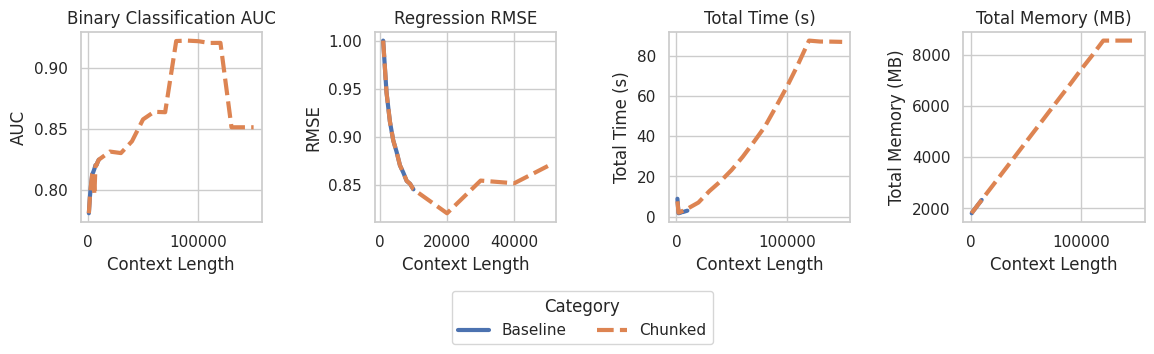

In [5]:
# set theme for sns as "whitegrid"
sns.set_theme(style="whitegrid")

# make grid of 4 plots
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# binary classification
sns.lineplot(
    df[(df["problem_type"] == "binary")],
        # | (df["problem_type"] == "multiclass")], 
    x="Context Length", 
    y="AUC",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[0],
    linewidth=3,
)

# regression
df_regression = df[df["problem_type"] == "regression"]
def process(row):
    row['RMSE'] = row['RMSE'] / df_regression[df_regression['dataset_name'] == row['dataset_name']]['RMSE'].max()
    return row
df_regression = df_regression.apply(process, axis=1)
df_regression.reset_index(inplace=True)
sns.lineplot(
    df_regression, 
    x="Context Length", 
    y="RMSE",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[1],
    linewidth=3,
)

# fitting time -- for longest dataset GiveMeSomeCredit
sns.lineplot(
    df[df['dataset_name'] == 'GiveMeSomeCredit'], 
    x="Context Length", 
    y="Total Time (s)",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[2],
    linewidth=3,
)
# log-log scale
# axs[1, 0].set_xscale('log')
# axs[1, 0].set_yscale('log')

# Memory -- for longest dataset GiveMeSomeCredit
sns.lineplot(
    df[df['dataset_name'] == 'GiveMeSomeCredit'], 
    x="Context Length", 
    y="Total Memory (MB)",
    hue="Attention",
    style="Attention",
    errorbar=None,  # disable error bars
    ax=axs[3],
    linewidth=3,
    estimator="max"
)

# set titles
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0].set_title("Binary Classification AUC")
axs[1].set_title("Regression RMSE")
axs[2].set_title("Total Time (s)")
axs[3].set_title("Total Memory (MB)")

# remove legends
handles, labels = axs[0].get_legend_handles_labels() # Get handles/labels from one of the axes
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), title='Category', ncol=len(labels))
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[3].get_legend().remove()

# save as pdf
plt.tight_layout()
plt.show()
fig.savefig("./figures/tabarena_long_results.pdf", bbox_inches='tight', dpi=300)

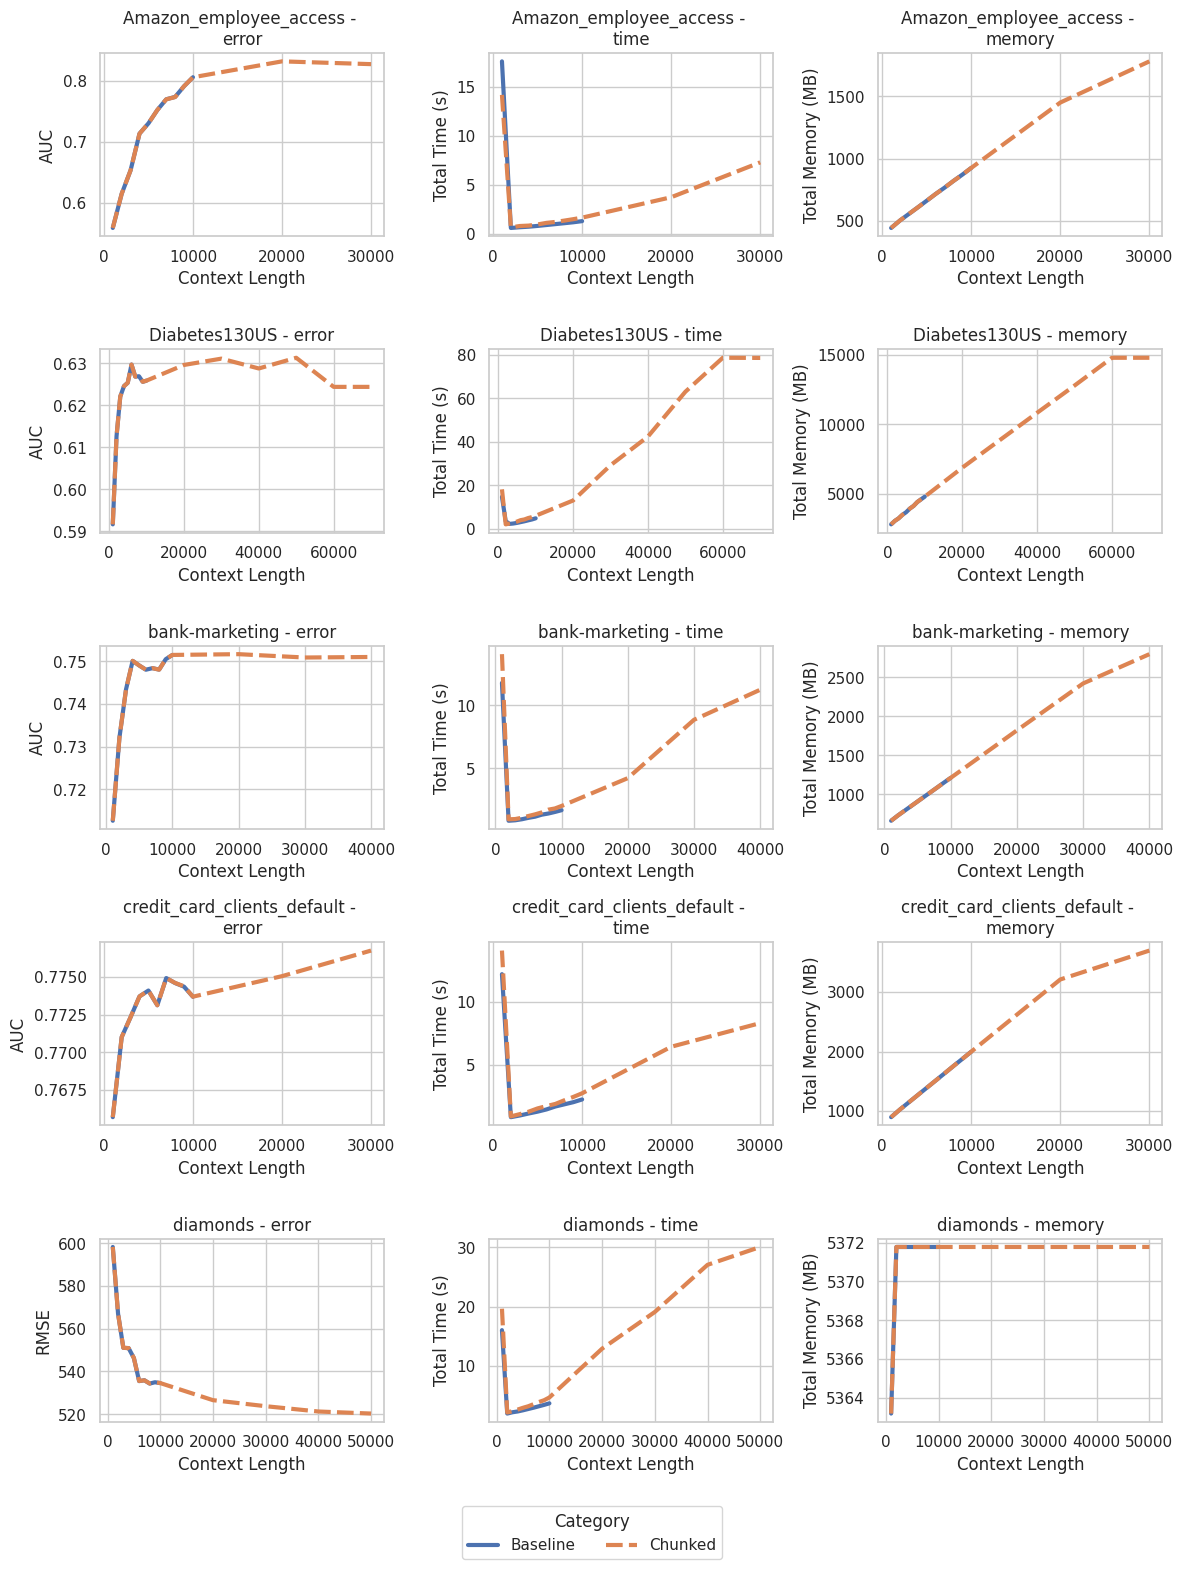

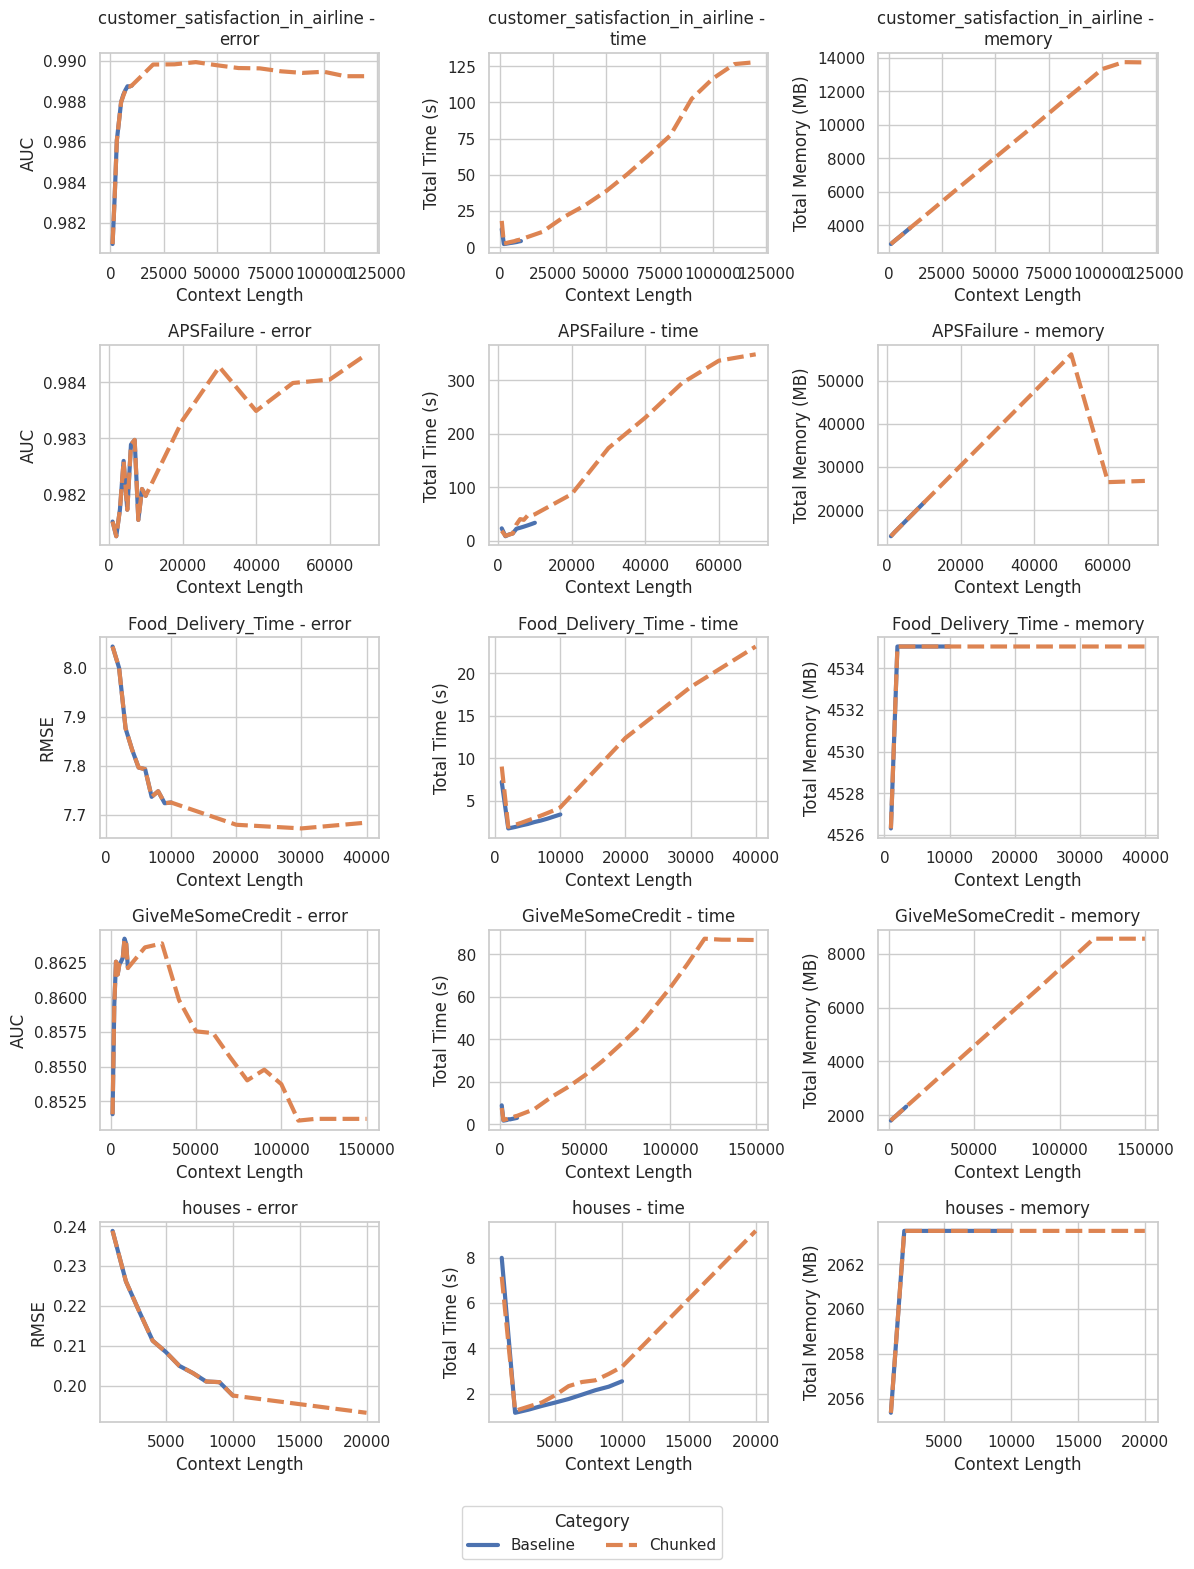

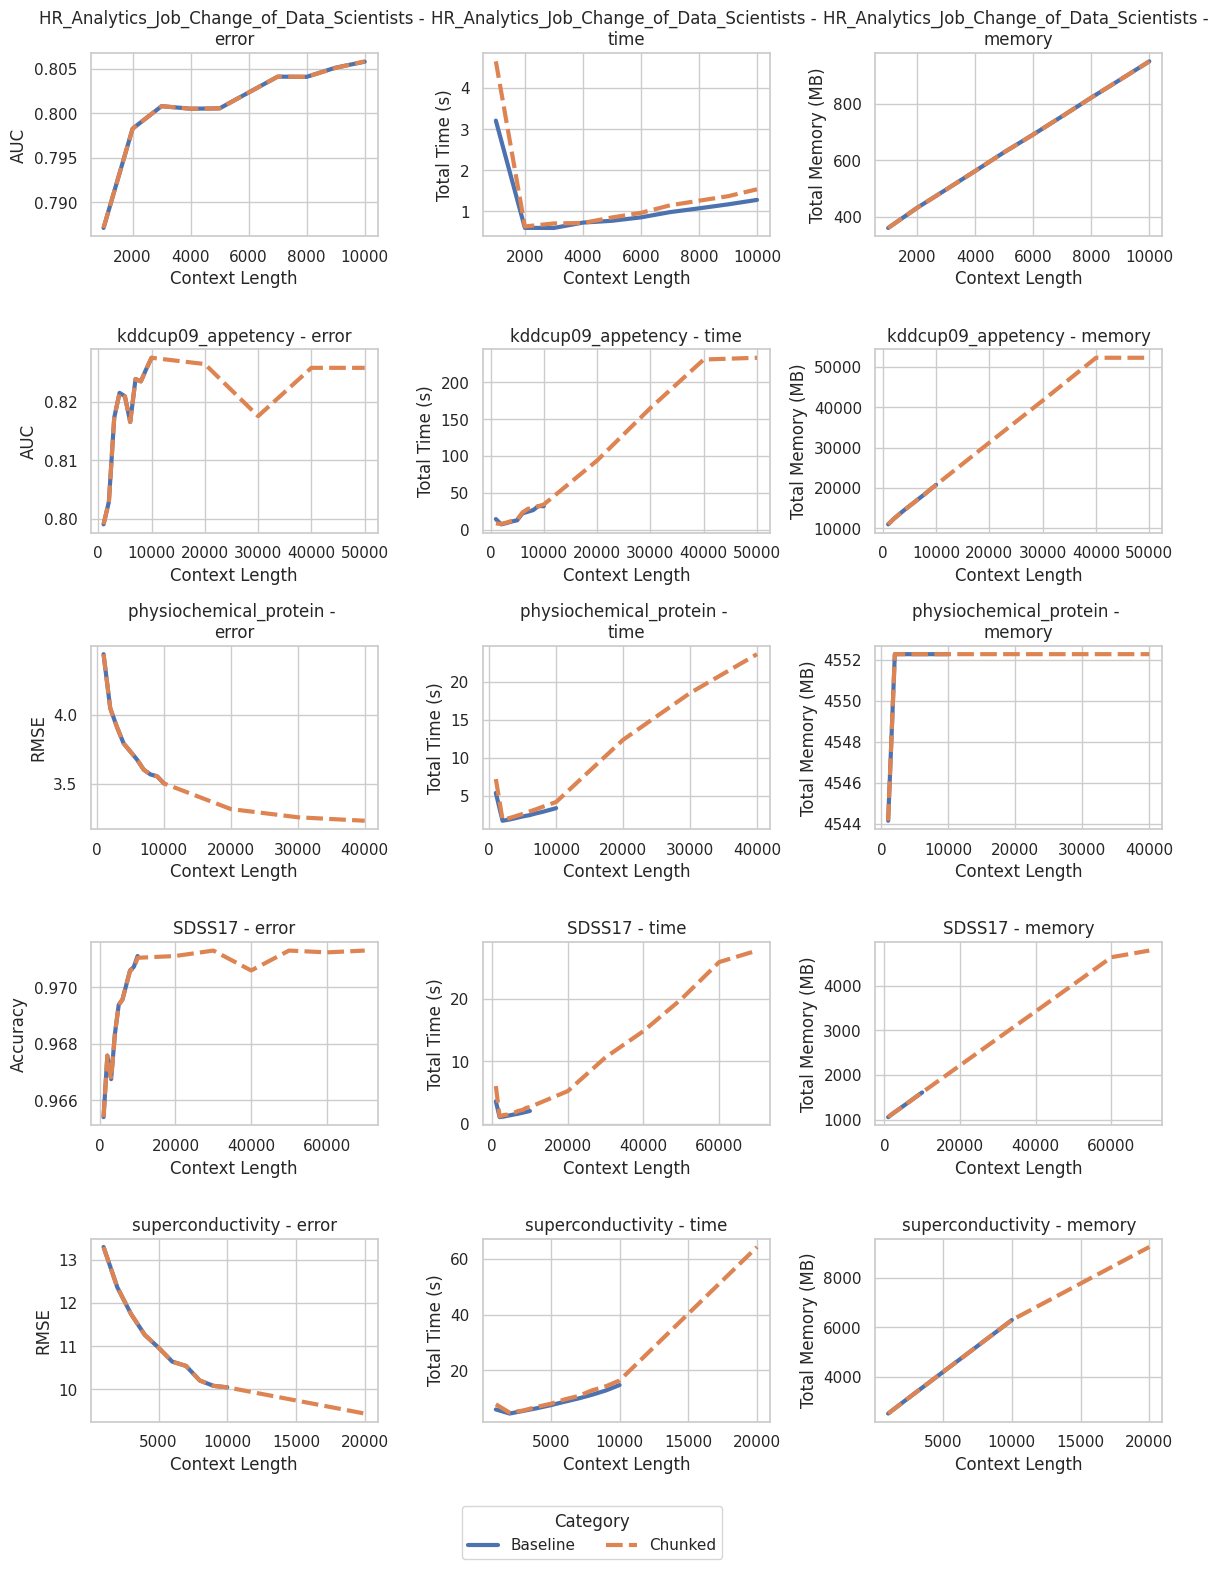

In [55]:
def plot_results(datasets, save_path):
    fig, axs = plt.subplots(len(datasets), 3, figsize=(12, 3 * len(datasets)))
    for i, dataset in enumerate(datasets):
        df_dataset = df[df["dataset_name"] == dataset]
        
        if df_dataset.problem_type.values[0] == "multiclass":
            sns.lineplot(
                df_dataset,
                x="Context Length",
                y="Accuracy",
                hue="Attention",
                style="Attention",
                errorbar=None,  # disable error bars
                ax=axs[i, 0],
                linewidth=3,
            )
        elif df_dataset.problem_type.values[0] == "regression":
            sns.lineplot(
                df_dataset,
                x="Context Length",
                y="RMSE",
                hue="Attention",
                style="Attention",
                errorbar=None,  # disable error bars
                ax=axs[i, 0],
                linewidth=3,
            )
        else:
            sns.lineplot(
                df_dataset,
                x="Context Length",
                y="AUC",
                hue="Attention",
                style="Attention",
                errorbar=None,  # disable error bars
                ax=axs[i, 0],
                linewidth=3,
            )
        
        # fitting time
        sns.lineplot(
            df_dataset, 
            x="Context Length", 
            y="Total Time (s)",
            hue="Attention",
            style="Attention",
            errorbar=None,  # disable error bars
            ax=axs[i, 1],
            linewidth=3,
        )
        # axs[i, 1].set_xscale('log')
        # axs[i, 1].set_yscale('log')

        # memory
        sns.lineplot(
            df_dataset, 
            x="Context Length", 
            y="Total Memory (MB)",
            hue="Attention",
            style="Attention",
            errorbar=None,  # disable error bars
            ax=axs[i, 2],
            linewidth=3,
        )

        # set titles
        if len(dataset) > 20:
            axs[i, 0].set_title(f"{dataset} - \nerror")
            axs[i, 1].set_title(f"{dataset} - \ntime")
            axs[i, 2].set_title(f"{dataset} - \nmemory")
        else: 
            axs[i, 0].set_title(f"{dataset} - error")
            axs[i, 1].set_title(f"{dataset} - time")
            axs[i, 2].set_title(f"{dataset} - memory")

    handles, labels = axs[0, 1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), title='Category', ncol=len(labels))
    for i, dataset in enumerate(datasets):
        axs[i, 0].get_legend().remove()
        axs[i, 1].get_legend().remove()
        axs[i, 2].get_legend().remove()

    plt.tight_layout()
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    


datasets = df.dataset_name.unique().tolist()
plot_results(datasets[:5], "./figures/tabarena_long_results_per_dataset_1.pdf") 
plot_results(datasets[5:10], "./figures/tabarena_long_results_per_dataset_2.pdf")
plot_results(datasets[10:15], "./figures/tabarena_long_results_per_dataset_3.pdf")